In [41]:
import numpy as np
import torch
import torch.nn.functional as F
import tntorch as tn
import pennylane as qml

In [42]:
tt = tn.randn([2]*5, ranks_tt=[2, 10, 5, 4])
tt /= tt.norm()
print(tt)
print("TT norm", tt.norm())

c = tt.cores[0]
cm = c.reshape(-1, 1)
norm = torch.sqrt(torch.mm(cm.T, cm))
print("Norm core 0: ", norm)

c = tt.cores[4]
cm = c.reshape(-1, 1)
norm = torch.sqrt(torch.mm(cm.T, cm))
print("Norm core 4: ", norm)

c = tt.cores[0]
rows = [0, 1]
cols = [2]
new = rows + cols
row_size = torch.prod(torch.tensor(c.shape)[rows]).item()
col_size = torch.prod(torch.tensor(c.shape)[cols]).item()
cp = c.permute(*new)
cr = cp.reshape(row_size, col_size)
cm = torch.mm(cr.T, cr)
print("ID core 0: ", cm)

c = tt.cores[4]
rows = [1, 2]
cols = [0]
new = rows + cols
row_size = torch.prod(torch.tensor(c.shape)[rows]).item()
col_size = torch.prod(torch.tensor(c.shape)[cols]).item()
cp = c.permute(*new)
cr = cp.reshape(row_size, col_size)
cm = torch.mm(cr.T, cr)
print("ID core 4: ", cm)

c = tt.cores[2]
rows = [0, 1]
cols = [2]
new = rows + cols
row_size = torch.prod(torch.tensor(c.shape)[rows]).item()
col_size = torch.prod(torch.tensor(c.shape)[cols]).item()
cp = c.permute(*new)
cr = cp.reshape(row_size, col_size)
cm = torch.mm(cr.T, cr)
print("ID core 2 right: ", cm)

c = tt.cores[2]
rows = [1, 2]
cols = [0]
new = rows + cols
row_size = torch.prod(torch.tensor(c.shape)[rows]).item()
col_size = torch.prod(torch.tensor(c.shape)[cols]).item()
cp = c.permute(*new)
cr = cp.reshape(row_size, col_size)
cm = torch.mm(cr.T, cr)
print("ID core 2 left: ", cm)


tt.orthogonalize(4)
print("------------AFTER------------")


c = tt.cores[0]
cm = c.reshape(-1, 1)
norm = torch.sqrt(torch.mm(cm.T, cm))
print("Norm core 0: ", norm)

c = tt.cores[4]
cm = c.reshape(-1, 1)
norm = torch.sqrt(torch.mm(cm.T, cm))
print("Norm core 4: ", norm)

c = tt.cores[0]
rows = [0, 1]
cols = [2]
new = rows + cols
row_size = torch.prod(torch.tensor(c.shape)[rows]).item()
col_size = torch.prod(torch.tensor(c.shape)[cols]).item()
cp = c.permute(*new)
cr = cp.reshape(row_size, col_size)
cm = torch.mm(cr.T, cr)
print("ID core 0: ", cm)

c = tt.cores[4]
rows = [1, 2]
cols = [0]
new = rows + cols
row_size = torch.prod(torch.tensor(c.shape)[rows]).item()
col_size = torch.prod(torch.tensor(c.shape)[cols]).item()
cp = c.permute(*new)
cr = cp.reshape(row_size, col_size)
cm = torch.mm(cr.T, cr)
print("ID core 4: ", cm)

c = tt.cores[2]
rows = [0, 1]
cols = [2]
new = rows + cols
row_size = torch.prod(torch.tensor(c.shape)[rows]).item()
col_size = torch.prod(torch.tensor(c.shape)[cols]).item()
cp = c.permute(*new)
cr = cp.reshape(row_size, col_size)
cm = torch.mm(cr.T, cr)
print("ID core 2 right: ", cm)

c = tt.cores[2]
rows = [1, 2]
cols = [0]
new = rows + cols
row_size = torch.prod(torch.tensor(c.shape)[rows]).item()
col_size = torch.prod(torch.tensor(c.shape)[cols]).item()
cp = c.permute(*new)
cr = cp.reshape(row_size, col_size)
cm = torch.mm(cr.T, cr)
print("ID core 2 left: ", cm)

5D TT tensor:

  2   2   2   2   2
  |   |   |   |   |
 (0) (1) (2) (3) (4)
 / \ / \ / \ / \ / \
1   2   10  5   4   1

TT norm tensor(1.)
Norm core 0:  tensor([[0.6650]])
Norm core 4:  tensor([[1.3363]])
ID core 0:  tensor([[ 0.4073, -0.1059],
        [-0.1059,  0.0350]])
ID core 4:  tensor([[ 0.8717, -0.4554, -0.4876, -0.2104],
        [-0.4554,  0.2581,  0.1736,  0.1208],
        [-0.4876,  0.1736,  0.5994,  0.0737],
        [-0.2104,  0.1208,  0.0737,  0.0567]])
ID core 2 right:  tensor([[ 5.1751, -0.5191,  0.8754, -0.4203, -1.0542],
        [-0.5191,  5.6482,  0.3928,  2.9462, -1.5234],
        [ 0.8754,  0.3928,  2.3452, -0.8459, -0.9373],
        [-0.4203,  2.9462, -0.8459,  4.8272, -0.9383],
        [-1.0542, -1.5234, -0.9373, -0.9383,  2.4940]])
ID core 2 left:  tensor([[ 1.1582, -0.5123, -0.0657, -0.2850, -0.1637, -0.1385,  0.7167,  0.0176,
          0.6972,  0.1151],
        [-0.5123,  2.8136,  1.1126,  0.4248, -1.6313,  1.0996, -0.1393,  0.0246,
         -1.4830, -0.9539],


In [43]:
def contract(tt, L):
    cores = tt.cores
    result = cores[0].clone().detach()
    for i in range(1, L):
        result = torch.tensordot(result, cores[i], dims=([result.dim() - 1], [0]))
        
    return result

tmp = contract(tt, L=2)
print(tmp.shape)

torch.Size([1, 2, 2, 4])


In [44]:
core = tt.cores[1]
print(core.shape)

def embed2unitary(Q):
    k = Q.shape[-1] # this always assumes Q is a tall matrix
    U, _, _ = torch.linalg.svd(Q, full_matrices=True)
    Q_ = torch.cat((Q, U[:, k:]), dim=1)
    return Q_

torch.Size([2, 2, 4])


In [45]:
dev = qml.device('default.qubit', wires=1)
U = 1 / np.sqrt(2) * np.array([[1, 1], [1, -1]])
U = 2*np.array([[0, 1], [1, 0]])

print(qml.math.einsum("...ij,...kj->...ik", U, qml.math.conj(U)))
dim = 2
print(qml.math.allclose(
                qml.math.einsum("...ij,...kj->...ik", U, qml.math.conj(U)),
                qml.math.eye(dim),
                atol=1e-6,
            ))

@qml.qnode(dev)
def example_circuit():
    qml.QubitUnitary(U, wires=0, unitary_check=False)
    return qml.expval(qml.PauliZ(0))
print(example_circuit())
drawer = qml.draw(example_circuit, show_all_wires=True, expansion_strategy="device")
print(drawer())

[[4 0]
 [0 4]]
False
-4.0
0: ──U(M0)─┤  <Z>


In [46]:
tt = tn.randn([2]*5, ranks_tt=[4, 4, 4, 2])

def compute_s(tt):
    s = int(torch.ceil(torch.log2(max(tt.ranks_tt))))
    return s

s = compute_s(tt)
def pad_cores(tt):
    s = compute_s(tt)
    chi = 2**s
    cores = tt.cores.copy()
    
    core = cores[0]
    rankR = chi - core.shape[-1]
    pad = (0, rankR)
    cores[0] = F.pad(core, pad)
    
    core = cores[-1]
    rankL = chi - core.shape[0]
    pad = (0, 0, 0, 0, 0, rankL)
    cores[-1] = F.pad(core, pad)

    for j in range(1, len(cores)-1):
        core = cores[j]
        rankL = chi - core.shape[0]
        rankR = chi - core.shape[-1]
        pad = (0, rankR, 0, 0, 0, rankL)
        cores[j] = F.pad(core, pad)

    tt_ = tn.Tensor(cores)      
    return tt_

tt_ = pad_cores(tt)
print(tt)
print(tt_)

diff = tt - tt_
print(diff.norm())

#print(tt.cores[0])
#print(tt.cores[0][0, 0, 0])
#print(tt.cores[0][0, 1, 0])
#print(tt_.cores[0])
#print(tt.cores[0][0, 0, 0])
#print(tt.cores[0][0, 1, 0])

#print(tt.cores[2])
#print(tt.cores[2][0, 0, 0])
#print(tt.cores[2][0, 1, 0])
#print(tt_.cores[2])
#print(tt.cores[2][0, 0, 0])
#print(tt.cores[2][0, 1, 0])

#print(tt.cores[4])
#print(tt.cores[4][0, 0, 0])
#print(tt.cores[4][0, 1, 0])
#print(tt_.cores[4])
#print(tt.cores[4][0, 0, 0])
#print(tt.cores[4][0, 1, 0])

tt_.orthogonalize(4)
tt.orthogonalize(4)
print(tt_)
diff = tt - tt_
print(diff.norm())

5D TT tensor:

  2   2   2   2   2
  |   |   |   |   |
 (0) (1) (2) (3) (4)
 / \ / \ / \ / \ / \
1   4   4   4   2   1

5D TT tensor:

  2   2   2   2   2
  |   |   |   |   |
 (0) (1) (2) (3) (4)
 / \ / \ / \ / \ / \
1   4   4   4   4   1

tensor(0.)
5D TT tensor:

  2   2   2   2   2
  |   |   |   |   |
 (0) (1) (2) (3) (4)
 / \ / \ / \ / \ / \
1   2   4   4   4   1

tensor(7.2337e-07)


In [47]:
print(s)
print(tt_)
core = contract(tt_, L=s+1)
print(core.shape)

2
5D TT tensor:

  2   2   2   2   2
  |   |   |   |   |
 (0) (1) (2) (3) (4)
 / \ / \ / \ / \ / \
1   2   4   4   4   1

torch.Size([1, 2, 2, 2, 4])


In [48]:
# left, inner and right reshapings
def left_core_reshape(core, s):
    rows = list(range(0, s+2))
    row_size = torch.prod(torch.tensor(core.shape)[rows]).item()
    Q = core.reshape(row_size, -1)
    return Q

def reg_core_reshape(core):
    rows = [0, 1]
    row_size = torch.prod(torch.tensor(core.shape)[rows]).item()
    Q = core.reshape(row_size, -1)
    return Q

#Q = left_core_reshape(core, s)
Q = reg_core_reshape(core)
print(Q.shape)

torch.Size([2, 16])


In [49]:
# tt to unitary list
def tt2unitaries(tt):
    N = tt.dim()
    tt_ = pad_cores(tt)
    tt_.orthogonalize(N-1)
    
    s = compute_s(tt)
    Us = []
    
    core = contract(tt_, L=s+1)
    Q0 = left_core_reshape(core, s)
    Us.append(embed2unitary(Q0))
    
    cores = tt_.cores.copy()
    for j in range(s+1, N):
        core = cores[j]
        Q = reg_core_reshape(core)
        Us.append(embed2unitary(Q))
        
    return Us

tt = tn.randn([2]*5, ranks_tt=[4, 4, 4, 2])
tt /= tt.norm()
print(tt)
Us = tt2unitaries(tt)
print(len(Us))

for U in Us:
    print(U.shape)

5D TT tensor:

  2   2   2   2   2
  |   |   |   |   |
 (0) (1) (2) (3) (4)
 / \ / \ / \ / \ / \
1   4   4   4   2   1

3
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])


In [50]:
# unitary list to circuit
num_qubits = 5
tt = tn.randn([2]*num_qubits, ranks_tt=4)
tt /= tt.norm()

# pad
tt_ = pad_cores(tt)
diff = tt - tt_
print(diff.norm())

# orthog
N = tt.dim()
tt_.orthogonalize(N-1)
print(tt_)

# unitaries
Us = tt2unitaries(tt)
U = Us[-3]
core = tt_.cores[-3]
core = contract(tt_, 3)
print(U.shape)
print(core.shape)

Q1 = U.T[:, :4]
Q2 = core.reshape(8, 4)
Q2_ = embed2unitary(Q2)
print(Q1.shape)
print(Q2.shape)
print(Q1)
print(Q2)
print(Q2_.T[:, :4])

print(torch.mm(U.T, U))

tensor(5.1619e-08)
5D TT tensor:

  2   2   2   2   2
  |   |   |   |   |
 (0) (1) (2) (3) (4)
 / \ / \ / \ / \ / \
1   2   4   4   4   1

torch.Size([8, 8])
torch.Size([1, 2, 2, 2, 4])
torch.Size([8, 4])
torch.Size([8, 4])
tensor([[ 0.0263,  0.3210,  0.6057, -0.3562],
        [-0.5467,  0.1925,  0.1595, -0.2794],
        [ 0.7231,  0.4959, -0.1910, -0.2462],
        [ 0.0825, -0.1660,  0.4299, -0.0939],
        [-0.0576, -0.0514, -0.3691,  0.0881],
        [-0.0178,  0.0883,  0.0640, -0.2331],
        [-0.3775,  0.7367, -0.2234,  0.2120],
        [-0.1568, -0.1826, -0.4430, -0.7865]])
tensor([[ 0.0263, -0.5467,  0.7231,  0.0825],
        [ 0.3210,  0.1925,  0.4959, -0.1660],
        [ 0.6057,  0.1595, -0.1910,  0.4299],
        [-0.3562, -0.2794, -0.2462, -0.0939],
        [ 0.3621, -0.0015, -0.0182,  0.1220],
        [-0.0786, -0.1560, -0.1182, -0.1769],
        [ 0.0996, -0.6248, -0.2320,  0.4958],
        [ 0.5053, -0.3819, -0.2569, -0.6929]])
tensor([[ 0.0263,  0.3210,  0.6057, -0

In [51]:
num_qubits = 5
tt = tn.randn([2]*num_qubits, ranks_tt=4)
tt /= tt.norm()
s = compute_s(tt)
dev = qml.device('default.qubit', wires=num_qubits)

@qml.qnode(dev)
def ttunitaries2circuit(Us, num_qubits, s):
    N = len(Us)
    count = 0
    for k in range(N-1, -1, -1):
        wires = list(range(num_qubits-count-s-1, num_qubits-count))
        qml.QubitUnitary(Us[k], wires=wires, unitary_check=False)
        count += 1

    return qml.state()

print(tt)
s = compute_s(tt)
Us = tt2unitaries(tt)
drawer = qml.draw(ttunitaries2circuit, wire_order=range(num_qubits), show_all_wires=True, expansion_strategy="device")
print(drawer(Us, num_qubits, s))
print("circuit: ", ttunitaries2circuit(Us, num_qubits, s).real)

psi = torch.zeros(32, 1)
psi[0] = 1.0

I = torch.eye(4)
U3 = Us[-1]
U3 = torch.kron(I, U3)
U2 = Us[-2]
I = torch.eye(2)
U2 = torch.kron(torch.kron(I, U2), I)
I = torch.eye(4)
U1 = Us[-3]
U1 = torch.kron(U1, I)

psi = torch.mm(U3, psi)
psi = torch.mm(U2, psi)
#psi = torch.mm(U1, psi)
print("psi.T: ", psi.T)

tt_ = pad_cores(tt)
tt_.orthogonalize(num_qubits-1)
print(tt_)
newcore = contract(tt_, s+1)
print(newcore.shape)
I = torch.eye(8)
Q3 = tt_.cores[-1]

print("=====================================")
print("Q3 reshaped: ", Q3.reshape(8, 1).T)
zero = torch.zeros(8, 1)
zero[0] = 1
tmp = torch.mm(Us[-1], zero)
print("U3: ", tmp.T)
print("=====================================")

Q2 = I[:, :4]
Q2 = Q2.reshape(4, 2, 4)
Q2 = tt_.cores[-2]

print("=====================================")
print("Q2 reshaped: ", Q2.reshape(8, 4))
U = Us[-2]
U = U.reshape(4, 2, 2, 4)
zero = torch.zeros(2, 1)
zero[0] = 1
U = torch.tensordot(U, zero, dims=([2], [0]))
#U = torch.permute(U, (0, 1, 2, 5, 4, 3))
print(U.shape)
U = U.reshape(8, 4)
print("U2: ", U)
print("=====================================")

print("Q2 shape", Q2.shape)
Q1 = I[:, :4]
Q1 = Q1.reshape(2, 2, 2, 4)

print(Q1.shape)
print(Q2.shape)
print(Q3.shape)

vec = torch.tensordot(Q1, Q2, dims=([-1], [0]))
vec = torch.tensordot(vec, Q3, dims=([-1], [0]))
print(vec.shape)
vec = vec.reshape(32)

print("psi = ", psi.T)
print("vec = ", vec)

5D TT tensor:

  2   2   2   2   2
  |   |   |   |   |
 (0) (1) (2) (3) (4)
 / \ / \ / \ / \ / \
1   4   4   4   4   1

0: ───────────────╭U(M2)─┤  State
1: ────────╭U(M1)─├U(M2)─┤  State
2: ─╭U(M0)─├U(M1)─╰U(M2)─┤  State
3: ─├U(M0)─╰U(M1)────────┤  State
4: ─╰U(M0)───────────────┤  State
circuit:  [ 0.41657219  0.24349081  0.25615693  0.32715968 -0.35350779 -0.13559547
  0.07755929 -0.04539408 -0.26081387 -0.18033928  0.04607883 -0.2336228
  0.26139017 -0.05460017 -0.03924405 -0.10991887  0.23314184  0.13477807
 -0.04301729  0.12649066 -0.21824978  0.04961916  0.06083101  0.07852535
 -0.01689734 -0.03756014 -0.00417508 -0.17514421  0.11628477  0.03729288
 -0.05193787 -0.02429253]
psi.T:  tensor([[-0.6789, -0.3048, -0.1493, -0.3372,  0.2109, -0.1123, -0.1732, -0.3013,
          0.1476,  0.1761, -0.1414,  0.1401, -0.1530,  0.0102,  0.1061, -0.0711,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.00

In [52]:
psi = ttunitaries2circuit(Us, num_qubits, s)
ttfull = tt.torch().reshape(2**num_qubits)
print(tt)
print(psi.shape)
print(ttfull.shape)
print(psi.real)
print("=======")
print(ttfull)
print("================DIFF===================")
diff = torch.tensor(psi.real) - ttfull
print(torch.linalg.norm(diff))

5D TT tensor:

  2   2   2   2   2
  |   |   |   |   |
 (0) (1) (2) (3) (4)
 / \ / \ / \ / \ / \
1   4   4   4   4   1

(32,)
torch.Size([32])
[ 0.41657219  0.24349081  0.25615693  0.32715968 -0.35350779 -0.13559547
  0.07755929 -0.04539408 -0.26081387 -0.18033928  0.04607883 -0.2336228
  0.26139017 -0.05460017 -0.03924405 -0.10991887  0.23314184  0.13477807
 -0.04301729  0.12649066 -0.21824978  0.04961916  0.06083101  0.07852535
 -0.01689734 -0.03756014 -0.00417508 -0.17514421  0.11628477  0.03729288
 -0.05193787 -0.02429253]
tensor([ 0.4166,  0.2435,  0.2562,  0.3272, -0.3535, -0.1356,  0.0776, -0.0454,
        -0.2608, -0.1803,  0.0461, -0.2336,  0.2614, -0.0546, -0.0392, -0.1099,
         0.2331,  0.1348, -0.0430,  0.1265, -0.2182,  0.0496,  0.0608,  0.0785,
        -0.0169, -0.0376, -0.0042, -0.1751,  0.1163,  0.0373, -0.0519, -0.0243])
================DIFF===================
tensor(6.1232e-07, dtype=torch.float64)


In [53]:
import numpy as np
import torch

def linear_FEM_basis(x, n):
    num_nodes = 2 ** n
    nodes = np.linspace(-1, 1, num_nodes)
    nodes = torch.tensor(nodes, dtype=torch.float64)

    # Initialize the output tensor
    values = torch.zeros(x.shape[0], num_nodes, dtype=torch.float64)
    
    # Distance between nodes
    h = 2 / (num_nodes - 1)

    # Handle tensor input for x
    for i in range(1, num_nodes):
        mask = (nodes[i - 1] <= x) & (x <= nodes[i])
        values[mask, i - 1] = (nodes[i] - x[mask]) / h
        values[mask, i] = (x[mask] - nodes[i - 1]) / h

    #values = torch.sqrt(values)
    #norms = torch.linalg.norm(values, dim=1, keepdim=True)
    #values /= norms
    return values.squeeze(0)#, norms

In [507]:
def find_grid_points(x, n, a=-1.0, b=1.0):
    num_segments = 2**n - 1
    length = b - a
    segment_length = length / num_segments

    # Ensure x is a torch tensor
    if not isinstance(x, torch.Tensor):
        x = torch.tensor(x, dtype=torch.float64)

    # Initialize left_point and right_point
    left_point = torch.zeros_like(x)
    right_point = torch.zeros_like(x)

    # Handle the case where x is left of a
    left_of_a = x < a
    left_point[left_of_a] = a - segment_length
    right_point[left_of_a] = a

    # Handle the case where x is right of b
    right_of_b = x > b
    left_point[right_of_b] = b
    right_point[right_of_b] = b + segment_length

    # Calculate position for values within the range [a, b]
    within_range = torch.logical_not(torch.logical_or(left_of_a, right_of_b))
    position = torch.zeros_like(x)
    position[within_range] = ((x[within_range] - a) / segment_length).floor()
    left_point[within_range] = a + position[within_range] * segment_length
    right_point[within_range] = left_point[within_range] + segment_length

    # Assign -1 to position where x is left of a, and -2 where x is right of b
    position[left_of_a] = -1
    position[right_of_b] = -2

    return left_point, right_point, position

# determine values \Phi(x) for k, k+1
def lin1dfembasis_nonz_vals(x, left, right, h):
    first = (right-x)/h
    second = (x-left)/h
    return first, second

# check if correct
n = 3
x = torch.tensor([-2.0, -1.0, -0.99, 0.0, -0.3, 0.9, 1.0, 1.3], dtype=torch.float64)
h = torch.tensor(2/(2**n-1), dtype=torch.float64)
left, right, pos = find_grid_points(x, n)
first, second = lin1dfembasis_nonz_vals(x, left, right, h)

print("x =", x)
print("Left Points:", left)
print("Right Points:", right)
print("Position:", pos)
print("First: ", first)
print("Second: ", second)
print("Should sum to one: ", first+second)

x = tensor([-2.0000, -1.0000, -0.9900,  0.0000, -0.3000,  0.9000,  1.0000,  1.3000],
       dtype=torch.float64)
Left Points: tensor([-1.2857, -1.0000, -1.0000, -0.1429, -0.4286,  0.7143,  1.0000,  1.0000],
       dtype=torch.float64)
Right Points: tensor([-1.0000, -0.7143, -0.7143,  0.1429, -0.1429,  1.0000,  1.2857,  1.2857],
       dtype=torch.float64)
Position: tensor([-1.,  0.,  0.,  3.,  2.,  6.,  7., -2.], dtype=torch.float64)
First:  tensor([ 3.5000,  1.0000,  0.9650,  0.5000,  0.5500,  0.3500,  1.0000, -0.0500],
       dtype=torch.float64)
Second:  tensor([-2.5000,  0.0000,  0.0350,  0.5000,  0.4500,  0.6500,  0.0000,  1.0500],
       dtype=torch.float64)
Should sum to one:  tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       dtype=torch.float64)


In [55]:
# TT for even case
def tt_lin1dfembasis_evenidx(first, second, idx, n):
    binidx = format(idx, '0{}b'.format(n))
    # check if not too long
    
    cores = []
    for j in range(n-1):
        k = int(binidx[j])
        core = torch.zeros((1, 2, 1))
        core[0, k, 0] = 1.0
        cores.append(core)
        
    core = torch.zeros(1, 2, 1)
    core[0, 0, 0] = first
    core[0, 1, 0] = second
    cores.append(core)
    tt = tn.Tensor(cores)
    
    return tt

n = 3
x = torch.tensor([-0.7], dtype=torch.float64)
left, right, pos = find_grid_points(x, n)
pos = int(pos.item())
h = 2.0/(2**n-1)
first, second = lin1dfembasis_nonz_vals(x, left, right, h)
tt = tt_lin1dfembasis_evenidx(first, second, pos, n)
print(tt)

# check
print("pos:", pos)
print("tt vectorized:")
print(tt.torch().reshape(2**n))
Phi = linear_FEM_basis(x, n)
print(Phi)

3D TT tensor:

  2   2   2
  |   |   |
 (0) (1) (2)
 / \ / \ / \
1   1   1   1

pos: 1
tt vectorized:
tensor([0.9500, 0.0500, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
tensor([0.0000, 0.9500, 0.0500, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
       dtype=torch.float64)


In [56]:
# TT for odd case
import math

def zerobit_position_odd(k, n):
    if k % 2 == 0:
        m = 0
    else :
        m = int(math.log2((-k) & (k + 1)))
    pos = n - m - 1
    return int(pos)

k = 13
n = 5
binidx = format(k, '0{}b'.format(n))
zerobit = zerobit_position_odd(k, n)

print("k:", k)
print("binary:", binidx)
print("zero bit:", zerobit)

def tt_lin1dfembasis_oddidx(first, second, idx, n):
    binidx = format(idx, '0{}b'.format(n))
    zerobit = zerobit_position_odd(idx, n)
    # check if not too long
    
    cores = []
    for j in range(zerobit):
        k = int(binidx[j])
        core = torch.zeros((1, 2, 1))
        core[0, k, 0] = 1.0
        cores.append(core)

    if zerobit != n-1:
        core = torch.zeros(1, 2, 2)
        core[0, 0, 1] = 1.0
        core[0, 1, 0] = 1.0 
        cores.append(core)
    
    for j in range(zerobit+1, n-1):
        core = torch.zeros((2, 2, 2))
        core[0, 0, 0] = 1.0
        core[1, 1, 1] = 1.0
        cores.append(core)
    
    if zerobit != n-1:
        core = torch.zeros(2, 2, 1)
        core[0, 0, 0] = second
        core[1, 1, 0] = first
        cores.append(core)
    else:
        core = torch.zeros(1, 2, 1)
        core[0, 0, 0] = second
        core[0, 1, 0] = first
        cores.append(core)
    
    tt = tn.Tensor(cores)
    
    return tt

n = 3
x = torch.tensor([0.65], dtype=torch.float64)
left, right, pos = find_grid_points(x, n)
pos = int(pos.item())
h = 2.0/(2**n-1)
first, second = lin1dfembasis_nonz_vals(x, left, right, h)
tt_even = tt_lin1dfembasis_evenidx(first, second, pos, n)
tt_odd = tt_lin1dfembasis_oddidx(first, second, pos, n)
print("TT EVEN")
print(tt_even)
print("TT ODD")
print(tt_odd)

# check
print("pos:", pos)
print("tt_even vectorized:")
print(tt_even.torch().reshape(2**n))
print("tt_odd vectorized:")
print(tt_odd.torch().reshape(2**n))
Phi = linear_FEM_basis(x, n)
print("exact Phi:")
print(Phi)

k: 13
binary: 01101
zero bit: 3
TT EVEN
3D TT tensor:

  2   2   2
  |   |   |
 (0) (1) (2)
 / \ / \ / \
1   1   1   1

TT ODD
3D TT tensor:

  2   2   2
  |   |   |
 (0) (1) (2)
 / \ / \ / \
1   1   2   1

pos: 5
tt_even vectorized:
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.2250, 0.7750, 0.0000, 0.0000])
tt_odd vectorized:
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2250, 0.7750, 0.0000])
exact Phi:
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2250, 0.7750, 0.0000],
       dtype=torch.float64)


In [57]:
num_qubits = 5
dev = qml.device('default.qubit', wires=num_qubits)
@qml.qnode(dev)
def linear1dFEMcircuit(x, num_qubits, sqrt=False, normalize=False):
    left, right, pos = find_grid_points(x, num_qubits)
    pos = int(pos.item())
    h = 2.0/(2**num_qubits-1)
    first, second = lin1dfembasis_nonz_vals(x, left, right, h)
    
    if sqrt:
        first = torch.sqrt(first)
        second = torch.sqrt(second)
        
    if normalize:
        norm = torch.sqrt(first*first + second*second)
        first /= norm
        second /= norm
    
    even = pos%2 == 0
    
    if even:
        tt = tt_lin1dfembasis_evenidx(first, second, pos, num_qubits)
    else:
        tt = tt_lin1dfembasis_oddidx(first, second, pos, num_qubits)
        
    s = compute_s(tt)
    Us = tt2unitaries(tt)
    N = len(Us)
    count = 0
    for k in range(N-1, -1, -1):
        wires = list(range(num_qubits-count-s-1, num_qubits-count))
        qml.QubitUnitary(Us[k], wires=wires, unitary_check=False)
        count += 1

    return qml.state()

x = torch.tensor([0.4], dtype=torch.float64)
Phi = linear_FEM_basis(x, num_qubits)
psi = linear1dFEMcircuit(x, num_qubits)
print("Phi")
print(Phi)
print("psi")
print(psi.real)
print(torch.tensor(psi.real)-Phi)

Phi
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.3000, 0.7000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000], dtype=torch.float64)
psi
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.30000001 0.69999999 0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
tensor([ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.1921e-08, -1.1921e-08,  0.0000e+00,  0.0000e+00

/tmp/ipykernel_2621780/1030421126.py:31: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at ../aten/src/ATen/native/Copy.cpp:276.)
  basis_functions[m, :] = torch.tensor(linear1dFEMcircuit(x_plot[m], num_qubits, sqrt=True))
/tmp/ipykernel_2621780/1030421126.py:21: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


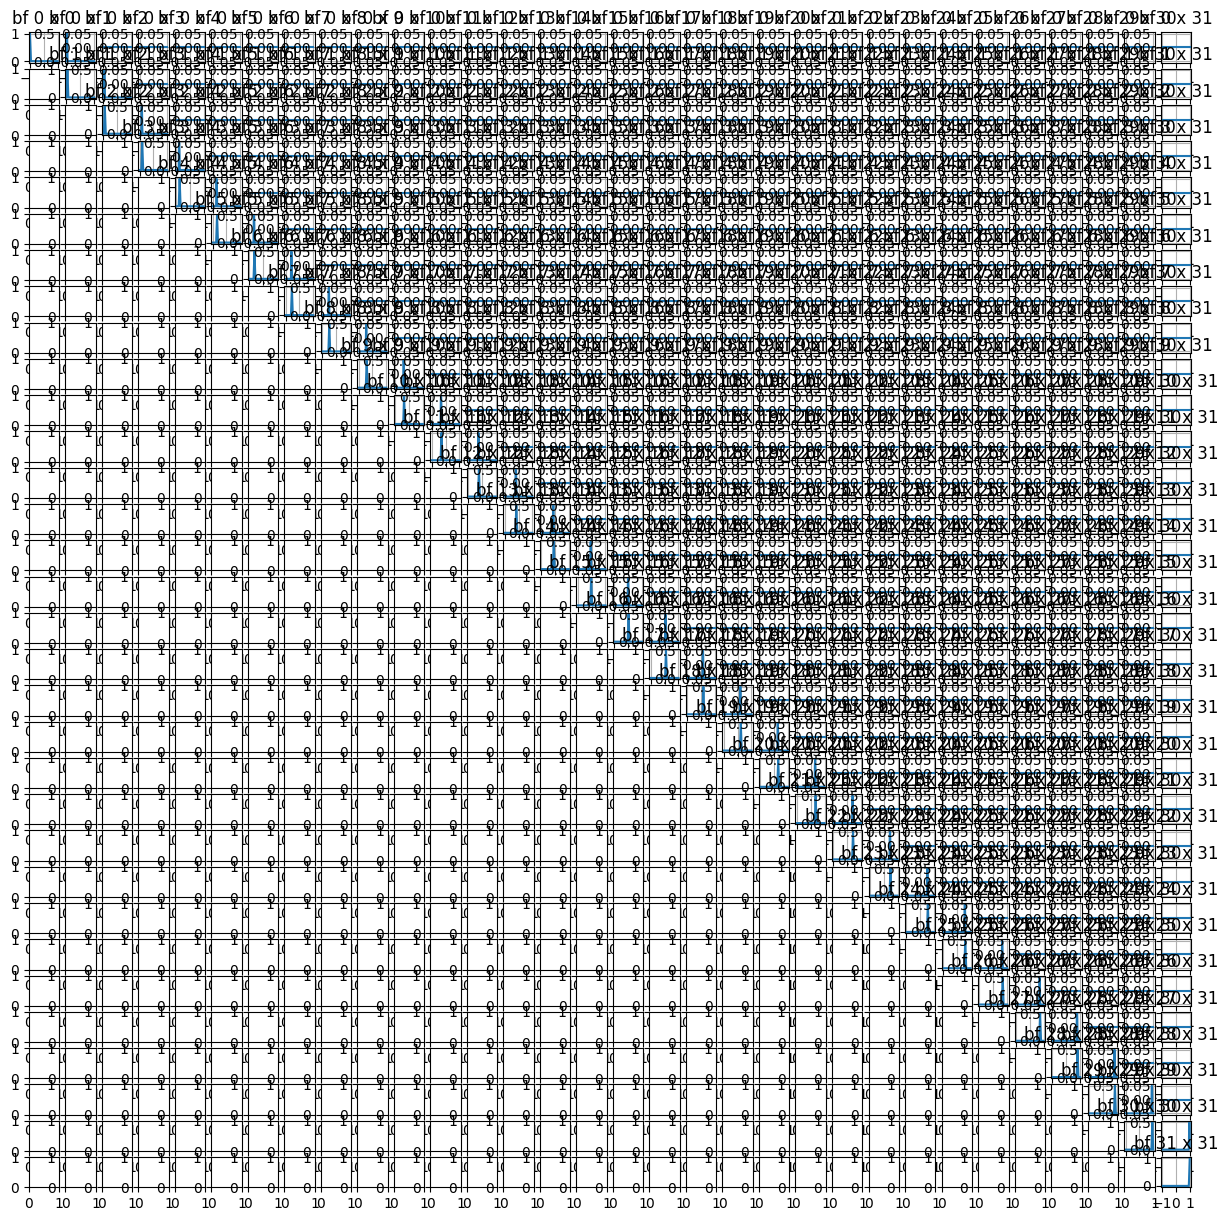

In [58]:
import matplotlib.pyplot as plt
import torch
import itertools

def plot_basis_combinations(x_values, basis_functions, n):
    s = 2**n
    grid_size=(s, s)
    num_plots = grid_size[0] * grid_size[1]
    _, axs = plt.subplots(grid_size[0], grid_size[1], figsize=(15, 15))

    # Generate all unique combinations of basis functions
    all_combinations = list(itertools.combinations_with_replacement(range(2**n), 2))
    selected_combinations = all_combinations[:num_plots]

    for idx, (i, j) in enumerate(selected_combinations):
        combined_basis = basis_functions[:, i]*basis_functions[:, j]
        axs[i, j].plot(x_values, combined_basis)
        axs[i, j].set_title(f"bf {i} x {j}")
        axs[i, j].grid(True)

    plt.tight_layout()
    plt.show()
    
# Generate x values for plotting
x_plot = torch.tensor(np.linspace(-1, 0.9999, 500))

# Generate the basis functions for each x in x_plot
M = len(x_plot)
basis_functions = torch.zeros(M, 2**num_qubits)
for m in range(M):
    basis_functions[m, :] = torch.tensor(linear1dFEMcircuit(x_plot[m], num_qubits, sqrt=True))
plot_basis_combinations(x_plot, basis_functions, num_qubits)

In [627]:
import pennylane as qml
from qulearn import qlayer
import torch


class Linear1DFEMEmbedding(qlayer.CircuitLayer):
    def __init__(self, num_qubits, a=-1.0, b=1.0, sqrt=False, normalize=False):
        super().__init__(num_qubits)
        self.num_qubits = num_qubits
        self.sqrt = sqrt
        self.normalize = normalize
        self.a = a
        self.b = b
        self.norm = 1.0

    def circuit(self, x):
        left, right, pos = find_grid_points(x, self.num_qubits, a=self.a, b=self.b)
        pos = int(pos.item())
        length = self.b - self.a
        h = length/(2**self.num_qubits-1)
        first, second = lin1dfembasis_nonz_vals(x, left, right, h)
    
        if self.sqrt:
            first = torch.sqrt(first)
            second = torch.sqrt(second)
        
        if pos == -1:
            self.norm = second
            for q in range(num_qubits):
                qml.Identity(wires=self.wires[q])
            return None    
        
        elif pos == -2:
            self.norm = first
            for q in range(num_qubits):
                qml.PauliX(wires=self.wires[q])
            return None

        self.norm = torch.sqrt(first*first + second*second)
        if self.normalize:
            first /= self.norm
            second /= self.norm
    
        even = pos%2 == 0

        if even:
            tt = tt_lin1dfembasis_evenidx(first, second, pos, num_qubits)
        else:
            tt = tt_lin1dfembasis_oddidx(first, second, pos, num_qubits)

        s = compute_s(tt)
        Us = tt2unitaries(tt)
        N = len(Us)
        count = 0
        for k in range(N-1, -1, -1):
            wires_idx = list(range(self.num_qubits-count-s-1, self.num_qubits-count))
            subwires = [self.wires[idx] for idx in wires_idx]
            qml.QubitUnitary(Us[k], wires=subwires, unitary_check=False)
            count += 1
            
            
    def compute_norm(self, x):
        left, right, pos = find_grid_points(x, self.num_qubits, a=self.a, b=self.b)
        pos = int(pos.item())
        length = self.b - self.a
        h = length/(2**self.num_qubits-1)
        first, second = lin1dfembasis_nonz_vals(x, left, right, h)
    
        if self.sqrt:
            first = torch.sqrt(first)
            second = torch.sqrt(second)
        
        if pos == -1:
            self.norm = second
            return self.norm
        elif pos == -2:
            self.norm = first
            return self.norm

        self.norm = torch.sqrt(first*first + second*second)
        return self.norm

In [542]:
import pennylane as qml
from qulearn import qlayer
from torch import nn
import math

class TwoQubitRotCXMPSLayer(qlayer.CircuitLayer):
    def __init__(
        self,
        wires,
        n_layers_mps = 1,
        n_layers_block = 1,
        reverse = False,
        cdevice = None,
        dtype = None,
    ) -> None:
        super().__init__(wires)

        self.n_layers_mps = n_layers_mps
        self.n_layers_block = n_layers_block
        self.reverse = reverse
        self.cdevice = cdevice
        self.dtype = dtype
        self.n_blocks = self.num_wires - 1
        
        self.weights = torch.nn.Parameter(
            torch.empty((self.n_layers_mps, self.n_blocks, 2,
                         self.n_layers_block, 3),
                        device=self.cdevice, dtype=self.dtype)
        )
        self.weights_post = torch.nn.Parameter(
            torch.empty((self.num_wires, 3),
                        device=self.cdevice, dtype=self.dtype)
        )
        
        nn.init.uniform_(self.weights, a=0.0, b=2 * math.pi)
        nn.init.uniform_(self.weights_post, a=0.0, b=2 * math.pi)


    def circuit(self, _ = None):
        
        for mps_layer_idx in range(self.n_layers_mps):
            for block_idx in range(self.n_blocks-1, -1, -1) if self.reverse else range(self.n_blocks):
                self._block(mps_layer_idx, block_idx)
        
        for i, q in enumerate(self.wires): 
            qml.Rot(
                self.weights_post[i, 0],
                self.weights_post[i, 1],
                self.weights_post[i, 2],
                q)
    
    def _block(self, mps_layer_idx, block_idx):
        qprev = self.wires[block_idx]
        qnext = self.wires[block_idx+1]
        
        for block_layer in range(self.n_layers_block):
            qml.Rot(
                self.weights[mps_layer_idx, block_idx, 0, block_layer, 0],
                self.weights[mps_layer_idx, block_idx, 0, block_layer, 1],
                self.weights[mps_layer_idx, block_idx, 0, block_layer, 2],
                qprev)
            qml.Rot(
                self.weights[mps_layer_idx, block_idx, 1, block_layer, 0],
                self.weights[mps_layer_idx, block_idx, 1, block_layer, 1],
                self.weights[mps_layer_idx, block_idx, 1, block_layer, 2],
                qnext)
            qml.CNOT(wires=(qprev, qnext))

In [543]:
import pennylane as qml
from qulearn import qlayer
from torch import nn
import math

class embedU(qlayer.CircuitLayer):
    def __init__(self, num_qubits, U):
        super().__init__(num_qubits)
        self.num_qubits = num_qubits
        self.U = U 

    def circuit(self, _):
        qml.QubitUnitary(self.U, wires=self.wires, unitary_check=False)

In [544]:
from qulearn import qlayer
import pennylane as qml
import torch

num_qubits = 3
embed = Linear1DFEMEmbedding(num_qubits, sqrt=False)
#embed = qlayer.ParallelIQPEncoding(num_qubits, num_features=1, n_repeat=1, base=3.0, omega=1.0)
n_layers = 1
var = qlayer.AltRotCXLayer(num_qubits, n_layers=n_layers)

num_mps_layers = 1
num_block_layers = 3
reverse = True
var = TwoQubitRotCXMPSLayer(num_qubits,  n_layers_mps=num_mps_layers, n_layers_block=num_block_layers, reverse=reverse)
var = embedU(num_qubits, U.conj().T)

hads = qlayer.HadamardLayer(num_qubits)
obs = qml.PauliZ(4)
I = qml.Identity(0)
Z0 = qml.PauliZ(0)
Z1 = qml.PauliZ(1)
Z2 = qml.PauliZ(2)
Z3 = qml.PauliZ(3)
Zn = qml.PauliZ(num_qubits-1)
obs = [I, Z0, Z1, Z2, Z3, Zn]
obs = [I, Z0]

obs = qml.Projector(basis_state=[1, 1, 1], wires=list(range(num_qubits)))
model = qlayer.MeasurementLayer(embed, observables=obs, measurement_type=qlayer.MeasurementType.Expectation)
#model = qlayer.HamiltonianLayer(embed, var, observables=obs)
drawer = qml.draw(model.qnode, show_all_wires=True, expansion_strategy="device")
x = torch.tensor([0.1])
print(drawer(x))
nump = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of parameters: ", nump)

0: ────────╭U(M1)─┤ ╭<|111⟩⟨111|>
1: ─╭U(M0)─╰U(M1)─┤ ├<|111⟩⟨111|>
2: ─╰U(M0)────────┤ ╰<|111⟩⟨111|>
Number of parameters:  0


tensor([-0.7500], dtype=torch.float64)
tensor([-0.6086], dtype=torch.float64)
tensor([-0.4672], dtype=torch.float64)
tensor([-0.3258], dtype=torch.float64)
tensor([-0.1843], dtype=torch.float64)
tensor([-0.0429], dtype=torch.float64)
tensor([0.0985], dtype=torch.float64)
tensor([0.2399], dtype=torch.float64)
tensor([0.3813], dtype=torch.float64)
tensor([0.5227], dtype=torch.float64)
tensor([0.6641], dtype=torch.float64)
tensor([0.8056], dtype=torch.float64)
tensor([0.9470], dtype=torch.float64)


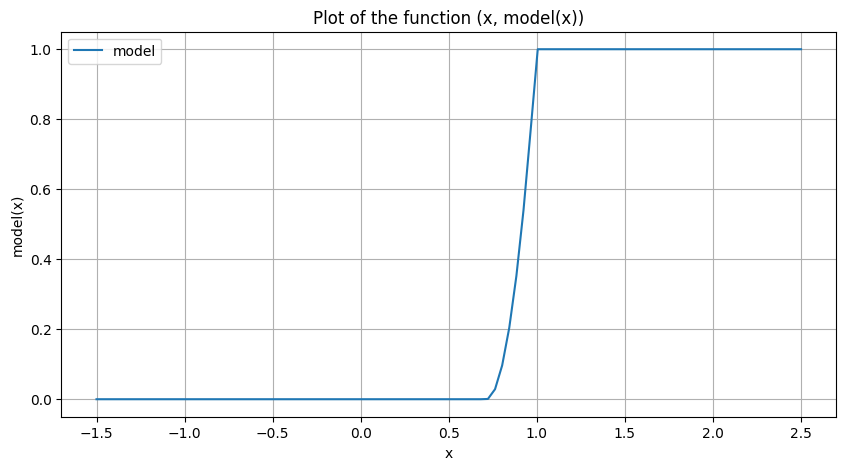

In [545]:
import torch
import matplotlib.pyplot as plt

x_values = torch.linspace(-1.5, 2.5, steps=100, dtype=torch.float64).reshape(-1, 1)

with torch.no_grad():
    y_values = model(x_values)

# Convert to numpy for plotting
x_values_np = x_values.numpy()
y_values_np = y_values.squeeze().numpy()

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(x_values_np, y_values_np, label="model")
plt.xlabel("x")
plt.ylabel("model(x)")
plt.title("Plot of the function (x, model(x))")
plt.legend()
plt.grid(True)
plt.show()

In [162]:
import torch

# Generate a sample of inputs
X = torch.linspace(-1, 1, 1000).reshape(-1, 1)


# Define a function to add Gaussian noise
def add_gaussian_noise(tensor, mean=0.0, std=0.01):
    return tensor + torch.randn(tensor.size()) * std + mean


# 1. Linear Relationship
def linear(X, m=2, c=3):
    return m * X + c


Y_linear = add_gaussian_noise(linear(X))


# 2. Polynomial Relationship (Quadratic for demonstration)
def polynomial(X, a=3, b=2, c=-5):
    return a * X**2 + b * X + c


Y_polynomial = add_gaussian_noise(polynomial(X))


# 3. Exponential Relationship
def exponential(X, a=2, b=0.5):
    return a * torch.exp(b * X)


Y_exponential = add_gaussian_noise(exponential(X))


# 4. Logarithmic Relationship
def logarithmic(X, a=3, b=2):
    return a * torch.log(X) + b


Y_logarithmic = add_gaussian_noise(logarithmic(X))


# 5. Trigonometric Relationship
def trigonometric(X, a=1, b=math.pi, c=0.):
    return a * torch.sin(b * X + c)


Y_trigonometric = add_gaussian_noise(trigonometric(X))


# 6. Power-law Relationship
def power_law(X, a=2, b=1.5):
    return a * X**b


Y_power_law = add_gaussian_noise(power_law(X))


# 7. Sigmoidal Relationship
def sigmoidal(X, L=1, k=0.5, x0=5):
    return L / (1 + torch.exp(-k * (X - x0)))


Y_sigmoidal = add_gaussian_noise(sigmoidal(X))


# 8. Gaussian Relationship
def gaussian(X, a=1.0, b=0, c=1):
    return a * torch.exp(-((X - b) ** 2) / (2 * c**2))


Y_gaussian = add_gaussian_noise(gaussian(X))


# 9. Step Function
def step_function(
    X, threshold1=-1.0, threshold2=0.0, low_value=0.0, mid_value=2, high_value=-1.0
):
    condition1 = X < threshold1
    condition2 = (X >= threshold1) & (X < threshold2)
    condition3 = X >= threshold2

    values = torch.zeros_like(X)
    values[condition1] = low_value
    values[condition2] = mid_value
    values[condition3] = high_value

    return values


Y_step = add_gaussian_noise(step_function(X))


def piecewise_linear_3segments(X, a=-0.714, b=0.143, m1=2, c1=0, m2=-3, m3=1):
    # Define linear functions for each segment
    linear_before_a = m1 * X + c1
    linear_between_a_b = m1 * a + c1 + m2 * (X - a)
    linear_after_b = m1 * a + c1 + m2 * (b - a) + m3 * (X - b)

    # Apply conditions for each segment
    conditions = [(X < a), (X >= a) & (X < b), (X >= b)]
    functions = [linear_before_a, linear_between_a_b, linear_after_b]

    output = torch.zeros_like(X)
    for condition, function in zip(conditions, functions):
        output[condition] = function[condition]

    return output


Y_piecewise_spiked = add_gaussian_noise(piecewise_linear_3segments(X))


def multidimstep(X, a=1.0):
    # Extract the first and second features
    X0 = X[:, 0]
    X1 = X[:, 1]

    # Check the condition X[1] > a * X[0]
    condition = X1 > a * X0

    # Initialize the output tensor Y
    Y = torch.zeros_like(X1)

    # Set Y values based on the condition
    Y[condition] = 1  # Set to +1 where condition is True
    Y[~condition] = -1  # Set to -1 where condition is False

    return Y.view(-1, 1)  # Reshape to make it a column vector


def high_low(X, low=1.0, high=30.0):
    return torch.sin(low * X) + 0.5 * torch.sin(high * X)


Y_high_low = add_gaussian_noise(high_low(X))

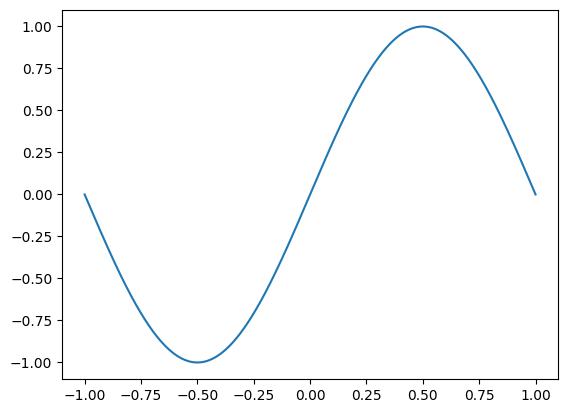

In [163]:
import matplotlib.pyplot as plt

# Create the scatter plot
#func = step_function
func = trigonometric
sigma = 0.0
Y = add_gaussian_noise(func(X), std=sigma)
plt.plot(X, Y)

# Show the plot
plt.show()

In [164]:
import torch
import logging
from torch.optim import Adam
from qulearn.trainer import SupervisedTrainer
from torch.utils.data import DataLoader, TensorDataset

# Data
N_train = 50
N_valid = 5
batch_size = 10
X_train = torch.linspace(-1, 1, N_train, dtype=torch.float64).reshape(-1, 1)
Y_train = add_gaussian_noise(func(X_train), std=sigma)
X_valid = torch.linspace(-1, 1, N_valid, dtype=torch.float64).reshape(-1, 1)
Y_valid = func(X_valid)
data_train = TensorDataset(X_train, Y_train)
data_valid = TensorDataset(X_valid, Y_valid)
loader_train = DataLoader(data_train, batch_size=batch_size, shuffle=False)
loader_valid = DataLoader(data_valid, batch_size=batch_size, shuffle=False)

In [165]:
import torch
import logging
from torch.optim import Adam, LBFGS
from qulearn.trainer import SupervisedTrainer
from torch.utils.data import DataLoader, TensorDataset
from torchmetrics.regression import MeanAbsolutePercentageError

# Trainer
lr = 0.1
optimizer = Adam(model.parameters(), lr=lr, amsgrad=True)
loss_fn = torch.nn.MSELoss()
metric = MeanAbsolutePercentageError()

In [166]:
logger = logging.getLogger("train_function")
logger.setLevel(level=logging.INFO)
num_epochs = 100
trainer = SupervisedTrainer(
    optimizer=optimizer,
    loss_fn=loss_fn,
    metrics={"MARE": metric},
    num_epochs=num_epochs,
    logger=logger,
)

In [167]:
# Train
trainer.train(model, train_data=loader_train, valid_data=loader_valid)

INFO:train_function:Train - Epoch: 1, Loss: 0.131959, Metrics: MARE: 20383.985147
INFO:train_function:Validate - Epoch: 1, Loss: 0.335949, Metrics: MARE: 207882.968750
INFO:train_function:Train - Epoch: 2, Loss: 0.101456, Metrics: MARE: 26640.496386
INFO:train_function:Validate - Epoch: 2, Loss: 0.255100, Metrics: MARE: 274440.562500
INFO:train_function:Train - Epoch: 3, Loss: 0.085515, Metrics: MARE: 6838.446764
INFO:train_function:Validate - Epoch: 3, Loss: 0.024527, Metrics: MARE: 76795.796875
INFO:train_function:Train - Epoch: 4, Loss: 0.035256, Metrics: MARE: 16365.297700
INFO:train_function:Validate - Epoch: 4, Loss: 0.094322, Metrics: MARE: 166115.531250
INFO:train_function:Train - Epoch: 5, Loss: 0.026795, Metrics: MARE: 12965.170490
INFO:train_function:Validate - Epoch: 5, Loss: 0.061915, Metrics: MARE: 136104.000000
INFO:train_function:Train - Epoch: 6, Loss: 0.031019, Metrics: MARE: 8767.336635
INFO:train_function:Validate - Epoch: 6, Loss: 0.031825, Metrics: MARE: 94379.304

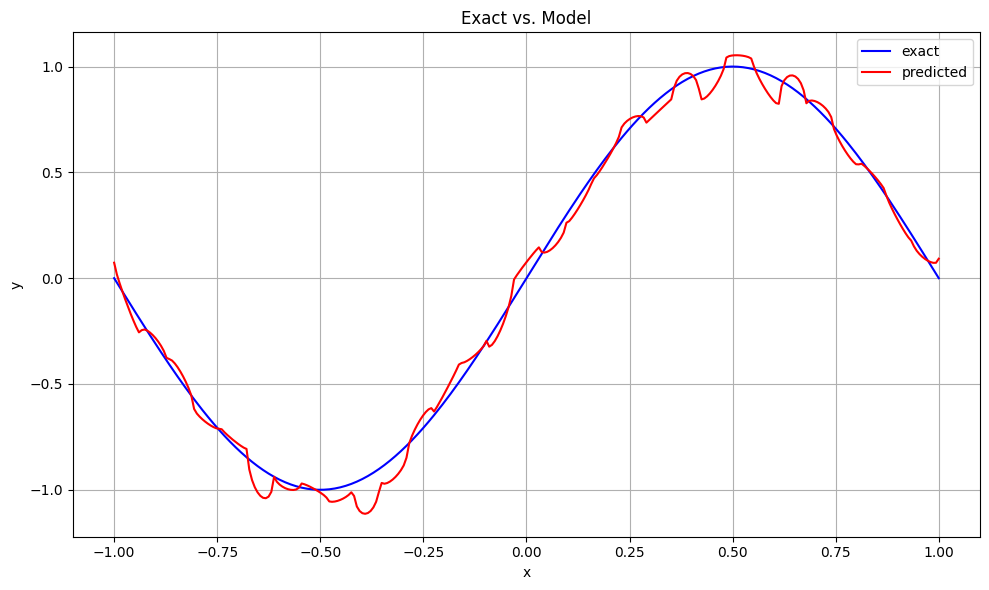

In [154]:
# Plotting
X = torch.linspace(-1, 1, 300, dtype=torch.float64).reshape(-1, 1)
Y_exact = func(X)
model.eval()
with torch.no_grad():
    Y_model = model(X)
plt.figure(figsize=(10, 6))
plt.plot(X, Y_exact, label="exact", color="blue")
plt.plot(X, Y_model, label="predicted", color="red")

# Adding title and labels
plt.title("Exact vs. Model")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()

# Display the plot
plt.grid(True)
plt.tight_layout()
plt.show()

In [200]:
import numpy as np

# Define purely complex numbers for the off-diagonal elements
nums = np.random.randn(6)
a = 0 + nums[0]*1j   # Example: purely imaginary number with imaginary part 1
b = 0 +nums[1]*1j   # Example: purely imaginary number with imaginary part 2
c = 0 +nums[2]*1j   # Example: purely imaginary number with imaginary part 3
d = 0 +nums[3]*1j   # Example: purely imaginary number with imaginary part 4
e = 0 +nums[4]*1j   # Example: purely imaginary number with imaginary part 5
f = 0 +nums[5]*1j   # Example: purely imaginary number with imaginary part 6

# Define your Hermitian matrix
H = np.array([[ 1,    a,    b,    c ],
              [ np.conj(a), 0,    d,    e ],
              [ np.conj(b), np.conj(d), 0,    f ],
              [ np.conj(c), np.conj(e), np.conj(f), -1 ]])

# Diagonalize the matrix
eigenvalues, eigenvectors = np.linalg.eigh(H)

# Print the eigenvalues
print("Matrix:", H)
print("Eigenvalues:", eigenvalues)

Matrix: [[ 1.+0.j          0.-1.89961775j  0.+0.22658997j  0.-0.40975701j]
 [ 0.+1.89961775j  0.+0.j          0.+0.41457242j  0.-0.29266821j]
 [ 0.-0.22658997j  0.-0.41457242j  0.+0.j          0.+0.02567953j]
 [ 0.+0.40975701j  0.+0.29266821j  0.-0.02567953j -1.+0.j        ]]
Eigenvalues: [-1.71251902 -0.88035468  0.05090306  2.54197065]


In [204]:
import numpy as np
import scipy.optimize

def generate_random_hermitian(n, specified_diagonal):
    # Create a matrix with random complex entries
    H = np.random.randn(n, n) + 1j * np.random.randn(n, n)
    # Make the matrix Hermitian
    H = (H + H.conj().T) / 2
    # Set the specified diagonal entries
    np.fill_diagonal(H, specified_diagonal)
    return H

def generate_random_unitary(n):
    # Generate a random nxn matrix
    X = np.random.randn(n, n) + 1j * np.random.randn(n, n)
    # Perform QR decomposition to get a unitary matrix
    Q, R = np.linalg.qr(X)
    return Q

def cost_function(U_flat, A, D_diagonal):
    U = U_flat.reshape(A.shape)
    transformed_matrix = np.dot(U.conj().T, np.dot(A, U))
    # Only compare diagonal elements
    cost = np.sum((np.diag(transformed_matrix) - D_diagonal)**2)
    return cost

def flatten_unitary_and_hermitian(U, D):
    # Flatten U
    U_flat = U.flatten()
    # Flatten upper triangular part of D (excluding diagonal)
    D_upper_flat = D[np.triu_indices_from(D, k=1)]
    return np.concatenate([U_flat, D_upper_flat])

def reconstruct_unitary_and_hermitian(x, n):
    # Reconstruct U
    U = x[:n**2].reshape((n, n))
    # Reconstruct D
    D = np.zeros((n, n), dtype=complex)
    D[np.triu_indices_from(D, k=1)] = x[n**2:]
    D += D.conj().T
    np.fill_diagonal(D, specified_diagonal)
    return U, D

def cost_function(x, A, n):
    U, D = reconstruct_unitary_and_hermitian(x, n)
    transformed_matrix = np.dot(U.conj().T, np.dot(A, U))
    return np.linalg.norm(transformed_matrix - D, 'fro')

# Example: 4x4 matrix
n = 4
A = np.diag([3, -1, 2, 4])  # Your specified diagonal matrix
specified_diagonal = np.array([1, 1, -1, -1])  # Specified diagonal entries of D

# Initial guess for U and D
U_initial = generate_random_unitary(n)
D_initial = generate_random_hermitian(n, specified_diagonal)
x_initial = flatten_unitary_and_hermitian(U_initial, D_initial)

# Optimize
result = scipy.optimize.minimize(cost_function, x_initial, args=(A, n), method='BFGS')

# Check the result
if result.success:
    U_optimal, D_optimal = reconstruct_unitary_and_hermitian(result.x, n)
    print("Found a unitary matrix U:")
    print(U_optimal)
    print("Resulting Hermitian matrix D:")
    print(D_optimal)
else:
    print("Optimization failed.")

/home/software/anaconda3/envs/QuLearn/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py:107: ComplexWarning: Casting complex values to real discards the imaginary part
  self.x = np.atleast_1d(x0).astype(float)
/home/software/anaconda3/envs/QuLearn/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py:243: ComplexWarning: Casting complex values to real discards the imaginary part
  self.x = np.atleast_1d(x).astype(float)


Optimization failed.


/home/software/anaconda3/envs/QuLearn/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py:243: ComplexWarning: Casting complex values to real discards the imaginary part
  self.x = np.atleast_1d(x).astype(float)


In [36]:
import sympy as sp

# Define the symbolic complex variables
c1, c2, c3, c4, c5, c6 = sp.symbols('c1 c2 c3 c4 c5 c6', complex=True)
c1 = 1j
c2 = 0.0
c3 = 0.0
c4 = 0.0
c5 = 0.0
c6 = 0.0

# Construct the Hermitian matrix
H = sp.Matrix([[1, c1, c2, c3],
               [sp.conjugate(c1), 0, c4, c5],
               [sp.conjugate(c2), sp.conjugate(c4), 0, c6],
               [sp.conjugate(c3), sp.conjugate(c5), sp.conjugate(c6), -1]])

# Diagonalize the matrix and compute eigenvalues
eigenvalues = H.eigenvals()

# Output the eigenvalues
print(eigenvalues)

{1.61803398874989: 1, -0.618033988749895: 1, 0: 1, -1.00000000000000: 1}


In [37]:
import numpy as np

# Define the numerical values for c1 to c6
c1 = complex(0, 0)  # Example: 1 + 2j
c2 = complex(0, 0)  # Example: 3 + 4j
c3 = complex(0, 0)  # Example: 5 + 6j
c4 = complex(0, 1)  # Example: 7 + 8j
c5 = complex(0, 0) # Example: 9 + 10j
c6 = complex(0, 0)# Example: 11 + 12j

# Construct the numerical matrix
H_num = np.array([[1, c1, c2, c3],
                  [np.conj(c1), 0, c4, c5],
                  [np.conj(c2), np.conj(c4), 0, c6],
                  [np.conj(c3), np.conj(c5), np.conj(c6), -1]])

# Compute eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eig(H_num)

# Output the eigenvalues and eigenvectors
print("Eigenvalues:", np.real(eigenvalues))
print("Eigenvectors:", eigenvectors)

Eigenvalues: [ 1. -1.  1. -1.]
Eigenvectors: [[-0.        +0.j         -0.        +0.j          1.        +0.j
   0.        +0.j        ]
 [ 0.70710678+0.j          0.70710678+0.j          0.        +0.j
   0.        +0.j        ]
 [-0.        -0.70710678j -0.        +0.70710678j  0.        +0.j
   0.        +0.j        ]
 [-0.        +0.j         -0.        +0.j          0.        +0.j
   1.        +0.j        ]]


In [63]:
import numpy as np
from scipy.optimize import minimize

def objective_function(c):
    # Construct the matrix
    H = np.array([[1, complex(0, c[0]), complex(0, c[1]), complex(0, c[2])],
                  [complex(0, -c[0]), 0, complex(0, c[3]), complex(0, c[4])],
                  [complex(0, -c[1]), complex(0, -c[3]), 0, complex(0, c[5])],
                  [complex(0, -c[2]), complex(0, -c[4]), complex(0, -c[5]), -1]])

    # Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(H)

    # Sort the eigenvalues in descending order and reorder eigenvectors
    idx = eigenvalues.argsort()[::-1]
    eigenvalues_sorted = eigenvalues[idx]
    eigenvectors_sorted = eigenvectors[:,idx]

    # Compute the error compared to target eigenvalues
    target_eigenvalues = [1, 1, -1, -1]
    error = sum((eigenvalues_sorted - target_eigenvalues)**2)

    return error

def returnU(c):
    # Construct the matrix
    H = np.array([[1, complex(0, c[0]), complex(0, c[1]), complex(0, c[2])],
                  [complex(0, -c[0]), 0, complex(0, c[3]), complex(0, c[4])],
                  [complex(0, -c[1]), complex(0, -c[3]), 0, complex(0, c[5])],
                  [complex(0, -c[2]), complex(0, -c[4]), complex(0, -c[5]), -1]])

    # Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(H)

    # Sort the eigenvalues in descending order and reorder eigenvectors
    idx = eigenvalues.argsort()[::-1]
    eigenvalues_sorted = eigenvalues[idx]
    eigenvectors_sorted = eigenvectors[:,idx]

    return eigenvectors_sorted


# Initial guesses for the imaginary parts of c1 to c6
initial_guesses = [0, 0, 0, 0, 0, 0]
objective_function(initial_guesses)

# Perform the optimization
result = minimize(objective_function, initial_guesses, method='BFGS')

# Output the optimized values
optimized_c = result.x
print("Optimized values for the imaginary parts of c1 to c6:", optimized_c)
print("Cost value:", result.fun)
U = returnU(optimized_c)
check = np.dot(U.conj().T, U)
print("Unitary:", U)
print("Check:", check)

Optimized values for the imaginary parts of c1 to c6: [-2.14680367e-08 -2.02883951e-08  8.84280981e-10  9.99999993e-01
 -1.96976737e-08 -2.11726760e-08]
Cost value: 1.8154602478292675e-15
Unitary: [[ 7.65580316e-01+0.00000000e+00j  6.43340330e-01+0.00000000e+00j
   8.03059170e-09+0.00000000e+00j  6.69081704e-09+0.00000000e+00j]
 [-3.12458146e-01+3.30625615e-01j  3.71827787e-01-3.93447209e-01j
  -3.58264593e-01-4.06936451e-01j -3.28064884e-01-3.13723825e-01j]
 [ 3.30625607e-01+3.12458154e-01j -3.93447216e-01-3.71827780e-01j
   4.06936456e-01-3.58264585e-01j  3.13723818e-01-3.28064892e-01j]
 [-6.56406532e-09+8.42710728e-11j  7.81129205e-09-7.87540829e-10j
   6.38767739e-01+6.38293834e-02j -7.66675112e-01-1.05289402e-02j]]
Check: [[ 1.00000000e+00+0.00000000e+00j  1.38777878e-16+3.32759494e-18j
   1.38777878e-16-8.50014503e-17j  2.77555756e-17-5.72458747e-17j]
 [ 1.38777878e-16-3.32759494e-18j  1.00000000e+00+0.00000000e+00j
  -1.66533454e-16+4.51028104e-17j -2.77555756e-17+3.98986399e-17

In [77]:
import numpy as np
from scipy.optimize import minimize

def construct_matrix(c):
    # Initialize an 8x8 matrix with zeros
    H = np.zeros((8, 8), dtype=complex)

    # Set the diagonal elements
    np.fill_diagonal(H, [1, 1, 0, 0, 0, 0, -1, -1])

    # Counter for c elements
    counter = 0

    # Fill the upper triangle of the matrix
    for i in range(8):
        for j in range(i+1, 8):
            H[i, j] = complex(0, c[counter])
            counter += 1

    # Fill the lower triangle with the conjugate
    H = H + H.conj().T - np.diag(H.diagonal())

    return H

def objective_function(c):
    # Construct the matrix
    H = construct_matrix(c)

    # Compute eigenvalues
    eigenvalues = np.linalg.eigvalsh(H)

    # Sort the eigenvalues in descending order
    eigenvalues_sorted = np.sort(eigenvalues)[::-1]

    # Target eigenvalues
    target_eigenvalues = [1, 1, 1, 1, -1, -1, -1, -1]

    # Sum of squared differences from the target eigenvalues
    error = np.sum((eigenvalues_sorted - target_eigenvalues)**2)

    return error

# Initial guesses for the imaginary parts of c1 to c28
initial_guesses = np.ones(28)

# Perform the optimization
result = minimize(objective_function, initial_guesses, method='BFGS')

# Optimized values
optimized_c = result.x
print("Optimized values for the imaginary parts of c1 to c28:", optimized_c)
print("Cost value:", result.fun)

Optimized values for the imaginary parts of c1 to c28: [ 3.97240827e-07  2.21497248e-08 -2.18192295e-07  1.34687411e-08
 -1.20533485e-07  6.00647559e-03  1.32884085e-03  5.15256883e-07
 -3.02343867e-08 -1.37517176e-06  2.86333692e-07 -2.77546457e-04
  6.00659574e-03  6.70015841e-01  4.84930268e-06  7.42347073e-01
  3.05031464e-07 -1.26732259e-07  7.42346847e-01 -4.77853558e-06
 -1.35762768e-06  1.60213403e-08  6.70015627e-01 -2.92447307e-08
 -2.90785382e-07  4.64011657e-07  6.02180525e-09 -5.82713674e-07]
Cost value: 1.4152096399592191e-09


In [78]:
H = construct_matrix(optimized_c)
print(H)
eigs, U = np.linalg.eigh(H)
print(eigs)

[[ 1.+0.00000000e+00j  0.+3.97240827e-07j  0.+2.21497248e-08j
   0.-2.18192295e-07j  0.+1.34687411e-08j  0.-1.20533485e-07j
   0.+6.00647559e-03j  0.+1.32884085e-03j]
 [ 0.-3.97240827e-07j  1.+0.00000000e+00j  0.+5.15256883e-07j
   0.-3.02343867e-08j  0.-1.37517176e-06j  0.+2.86333692e-07j
   0.-2.77546457e-04j  0.+6.00659574e-03j]
 [ 0.-2.21497248e-08j  0.-5.15256883e-07j  0.+0.00000000e+00j
   0.+6.70015841e-01j  0.+4.84930268e-06j  0.+7.42347073e-01j
   0.+3.05031464e-07j  0.-1.26732259e-07j]
 [ 0.+2.18192295e-07j  0.+3.02343867e-08j  0.-6.70015841e-01j
   0.+0.00000000e+00j  0.+7.42346847e-01j  0.-4.77853558e-06j
   0.-1.35762768e-06j  0.+1.60213403e-08j]
 [ 0.-1.34687411e-08j  0.+1.37517176e-06j  0.-4.84930268e-06j
   0.-7.42346847e-01j  0.+0.00000000e+00j  0.+6.70015627e-01j
   0.-2.92447307e-08j  0.-2.90785382e-07j]
 [ 0.+1.20533485e-07j  0.-2.86333692e-07j  0.-7.42347073e-01j
   0.+4.77853558e-06j  0.-6.70015627e-01j  0.+0.00000000e+00j
   0.+4.64011657e-07j  0.+6.02180525e-09j

In [548]:
import numpy as np
import pennylane as qml
from scipy.stats import unitary_group

num_qubits = 5

def generate_random_unitary(n):
    matrix_size = 2 ** n
    unitary_matrix = unitary_group.rvs(matrix_size)
    return unitary_matrix

# Example usage
U1 = generate_random_unitary(num_qubits)
U2 = generate_random_unitary(num_qubits)

In [549]:
import pennylane as qml

@qml.qnode(qml.device('default.qubit', wires=range(num_qubits+1)), interface="torch")
def innerp_circuit(U1, U2):
    qml.Hadamard(0)
    qml.ControlledQubitUnitary(U1, control_wires=[0], wires=range(1, num_qubits+1))
    qml.PauliX(0)
    qml.ControlledQubitUnitary(U2, control_wires=[0], wires=range(1, num_qubits+1))
    qml.Hadamard(0)
    
    return qml.expval(qml.PauliZ(0))

def Uf(num_qubits):
    qml.PauliX(0)
    for idx in range(num_qubits):
        qml.Hadamard(wires=idx)

def psi(initlayer_weights, weights, num_qubits, num_layers):
    wires = list(range(num_qubits))
    for i, q in enumerate(wires):
        qml.RY(initlayer_weights[i], q)
    
    for layer in range(num_layers):
        for i in range(0, len(wires) - 1, 2):
            qml.CZ(wires=[wires[i], wires[i + 1]])
            qml.RY(
                weights[layer, i],
                wires[i],
            )
            qml.RY(
                weights[layer, i + 1],
                wires[i + 1],
            )

        offset = int(num_qubits / 2) * 2
        for i in range(1, len(wires) - 1, 2):
            qml.CZ(wires=[wires[i], wires[i + 1]])
            qml.RY(
                weights[layer, offset + i - 1],
                wires[i],
            )
            qml.RY(
                weights[layer, offset + i],
                wires[i + 1],
            )
            
@qml.qnode(qml.device('default.qubit', wires=range(num_qubits)), interface="torch")
def Aeven(initlayer_weights, weights, num_qubits, num_layers):
    psi(initlayer_weights, weights, num_qubits, num_layers)
    qml.Hadamard(num_qubits-1)
    return qml.expval(qml.PauliZ(num_qubits-1))

@qml.qnode(qml.device('default.qubit', wires=range(num_qubits)), interface="torch")
def Aodd_IX(initlayer_weights, weights, num_qubits, num_layers):
    psi(initlayer_weights, weights, num_qubits, num_layers)
    for idx in range(1, num_qubits):
        ctrl_wires = list(range(idx, num_qubits))
        qml.ctrl(qml.PauliX, control=ctrl_wires)(idx-1)
        
    qml.PauliX(num_qubits-1)
    qml.Hadamard(num_qubits-1)
    return qml.expval(qml.PauliZ(num_qubits-1))

@qml.qnode(qml.device('default.qubit', wires=range(num_qubits)), interface="torch")
def Aodd_I0X(initlayer_weights, weights, num_qubits, num_layers):
    psi(initlayer_weights, weights, num_qubits, num_layers)
    for idx in range(1, num_qubits):
        ctrl_wires = list(range(idx, num_qubits))
        qml.ctrl(qml.PauliX, control=ctrl_wires)(idx-1)
        
    qml.PauliX(num_qubits-1)
    qml.Hadamard(num_qubits-1)
    I0 = qml.Projector(basis_state=[0]*(num_qubits-1), wires=list(range(0, num_qubits-1)))   
    return qml.expval(I0 @ qml.PauliZ(num_qubits-1))

In [550]:
import pennylane as qml
import torch

num_layers = 3
def cost_poisson(initlayer_weights, weights):
    Uf_mat = qml.matrix(Uf)(num_qubits)
    Upsi_mat = qml.matrix(psi)(initlayer_weights, weights, num_qubits, num_layers)
    innerp = innerp_circuit(Uf_mat, Upsi_mat)
    
    even = Aeven(initlayer_weights, weights, num_qubits, num_layers)
    odd_IX = Aodd_IX(initlayer_weights, weights, num_qubits, num_layers)
    odd_I0X = Aodd_I0X(initlayer_weights, weights, num_qubits, num_layers)
 
    op = 2.0-even-odd_IX+odd_I0X
    cost = -0.5*innerp**2/op
    
    return cost
    
initlayer_weights = torch.randn(num_qubits, requires_grad=True)
weights = torch.randn(num_layers, 2*(num_qubits-1), requires_grad=True)
cost = cost_poisson(initlayer_weights, weights)
print(initlayer_weights.requires_grad)
print(cost.requires_grad)
print(cost)

True
True
tensor(-0.0014, dtype=torch.float64, grad_fn=<DivBackward0>)


In [551]:
import torch
steps = 100
opt = torch.optim.Adam([initlayer_weights, weights], lr = 0.1)

def closure():
    opt.zero_grad()
    loss = cost_poisson(initlayer_weights, weights)
    loss.backward()
    return loss

for it in range(steps):
    opt.step(closure)
    cost = cost_poisson(initlayer_weights, weights)
    print("Step {:3d}       cost = {:9.7f}".format(it, cost))

Step   0       cost = -0.0118776
Step   1       cost = -0.0394499
Step   2       cost = -0.1103874
Step   3       cost = -0.2689311
Step   4       cost = -0.6142007
Step   5       cost = -1.2540709
Step   6       cost = -1.7496454
Step   7       cost = -2.2035262
Step   8       cost = -2.8013687
Step   9       cost = -3.5823347
Step  10       cost = -3.9617097
Step  11       cost = -4.1728706
Step  12       cost = -4.5655673
Step  13       cost = -4.3534981
Step  14       cost = -4.4853319
Step  15       cost = -4.5430734
Step  16       cost = -4.6028305
Step  17       cost = -4.6902061
Step  18       cost = -4.6467345
Step  19       cost = -4.9328011
Step  20       cost = -5.2231150
Step  21       cost = -5.4548955
Step  22       cost = -5.5379641
Step  23       cost = -5.6917557
Step  24       cost = -5.9426617
Step  25       cost = -6.2661697
Step  26       cost = -6.7685499
Step  27       cost = -7.4021906
Step  28       cost = -7.6729591
Step  29       cost = -7.7365786
Step  30  

In [616]:
import pennylane as qml

@qml.qnode(qml.device('default.qubit', wires=range(num_qubits)), interface="torch")
def extract_psi(initlayer_weights, weights, num_qubits, num_layers):
    psi(initlayer_weights, weights, num_qubits, num_layers)
    return qml.state()

vec = extract_psi(initlayer_weights, weights, num_qubits, num_layers)
print(vec)

tensor([ 0.0492+0.j,  0.0945+0.j,  0.1382+0.j,  0.1696+0.j,  0.1954+0.j,  0.2152+0.j,
         0.2212+0.j,  0.2269+0.j,  0.2303+0.j,  0.2202+0.j,  0.2043+0.j,  0.1843+0.j,
         0.1502+0.j,  0.1100+0.j,  0.0655+0.j,  0.0125+0.j, -0.0479+0.j, -0.0941+0.j,
        -0.1343+0.j, -0.1706+0.j, -0.1987+0.j, -0.2236+0.j, -0.2407+0.j, -0.2451+0.j,
        -0.2512+0.j, -0.2405+0.j, -0.2244+0.j, -0.2018+0.j, -0.1728+0.j, -0.1398+0.j,
        -0.0988+0.j, -0.0513+0.j], dtype=torch.complex128,
       grad_fn=<SqueezeBackward0>)


In [628]:
import pennylane as qml
import numpy as np
def eval_basis(x, Upsi, num_qubits):
    h = 2.0/(2**num_qubits+1)
    a = -1.0+h
    b = 1.0-h
    basis = Linear1DFEMEmbedding(num_qubits, a=a, b=b, sqrt=False, normalize=True)
    norm = basis.compute_norm(x)
    Ubasis = qml.matrix(basis.circuit, wire_order=list(range(num_qubits)))(x)
    result = norm*innerp_circuit(Ubasis, Upsi)
    
    N = 2**num_qubits
    zero = np.zeros(N)
    zero[0] = 1
    psi = np.dot(Upsi.detach().numpy(), zero)
    Ub = np.dot(Ubasis, zero)
    
    return result

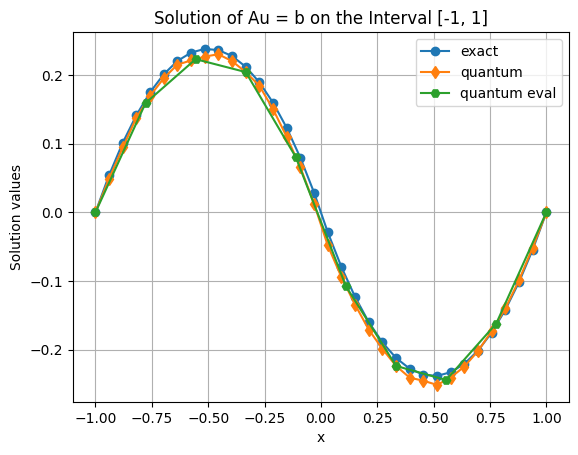

In [638]:
import numpy as np
import math
from scipy.sparse import diags
from scipy.linalg import solve
import pennylane as qml

# Define the size of the matrix
N = 2**num_qubits       

# Create the tridiagonal matrix A
diagonals = [[-1]*(N-1), [2]*N, [-1]*(N-1)]
A = diags(diagonals, offsets=[-1, 0, 1]).toarray()

# Create the right-hand side vector b
b = np.ones(N)
b[int(N/2):] *= -1
b /= math.sqrt(N)                                                                    

# Solve Ax = b
u = solve(A, b)
u /= np.linalg.norm(u)
# Create discrete points x_k
x_k = np.linspace(-1, 1, N+2)
ub = np.zeros(N+2)
ub[1:-1] = u

# quantum
ubq = torch.zeros(N+2)
ubq[1:-1] = psi_vec

# Plotting
plt.plot(x_k, ub, 'o-', label="exact")
plt.plot(x_k, ubq.detach().numpy(), 'd-', label="quantum")


xk = torch.linspace(-1.0, 1.0, steps=10, dtype=torch.float64).reshape(-1, 1)
yk = torch.zeros_like(xk)
Upsi = qml.matrix(psi, wire_order=list(range(num_qubits)))(initlayer_weights, weights, num_qubits, num_layers)
for i, x in enumerate(xk):
    yk[i] = eval_basis(x, Upsi, num_qubits)
    
plt.plot(xk, yk.detach().numpy(), 'H-', label="quantum eval")
plt.xlabel('x')
plt.ylabel('Solution values')
plt.title('Solution of Au = b on the Interval [-1, 1]')
plt.legend()
plt.grid(True)
plt.show()

In [423]:
x = psi_vec.detach().numpy()
innerp_exact = np.dot(x, b)

Uf_mat = qml.matrix(Uf)(num_qubits)
Upsi_mat = qml.matrix(psi)(initlayer_weights, weights, num_qubits, num_layers)
innerp_quantum = innerp_circuit(Uf_mat, Upsi_mat)

print(innerp_exact)
print(innerp_quantum.item())
print("=====================")

xAx_exact = np.dot(x, np.dot(A, x))

even = Aeven(initlayer_weights, weights, num_qubits, num_layers)
odd_IX = Aodd_IX(initlayer_weights, weights, num_qubits, num_layers)
odd_I0X = Aodd_I0X(initlayer_weights, weights, num_qubits, num_layers)
xAx_quantum = 2.0-even-odd_IX+odd_I0X
print(xAx_exact)
print(xAx_quantum.item())
print("=====================")

X = np.array([[0, 1], [1, 0]])
I = np.eye(2**(n-1))
IX = np.kron(I, X)
exact = np.dot(x, np.dot(IX, x))
quantum = even
print(exact)
print(quantum.item())
print("=====================")

size = 2**num_qubits
Odd = np.zeros((size, size))

# Set the off-diagonal entries
for i in range(1, size):
    if i % 2 != 1:
        Odd[i, i-1] = -1
        Odd[i-1, i] = -1

# Set the last element of the first row and first element of the last row
Odd[0, -1] = -1
Odd[-1, 0] = -1

exact = np.dot(x, np.dot(-Odd, x))
quantum = odd_IX
print(exact)
print(quantum.item())

0.2375730979041346
0.23757303625353432
1.9629848022728131
1.962984451240967
0.9908697224324395
0.9908697224324394
-0.9539235105770828
-0.9539235105770827
